In [ ]:
'''
PPCA v1.1 

STEP 2: RESIDENTIAL BUILDINGS CLASSIFICATION

Author: Perez, Joan

This script creates a column 'type' within the OSM building data with three possible values (# 0 : Null ; 1: residential or mixed-use ; 2: 
non-residential). Values are filled using the OSM attributes 'building_type' : apartments', 'barracks', 'house', 'residential', 'bungalow',
'cabin', 'detached', 'dormitory', 'farm', 'static_caravan', 'semidetached_house' & 'stilt_house' are considered as residential or mixed-use
buildings. The classification is refined by attributing 0 values to Null values based on the spatial relationships with non-populated OSM 
land use areas. Final score of classified buildings vs buldings with Null values are printed and mapped. This script then estimated the 
Null values using the morphometric indicators calculated in PPCA STEP 1 using a Decision Tree Classifier. It splits the dataset into training
and testing subsets based on a specified training ratio. It then trains the classifier using the training set and evaluates its accuracy on
the test set. the trained model is used to predict the Null values for 'type'. Within the output, a new variable 'type_filled' is created 
with two modalities (1 : residential or mixed-use ; 2 : non-residential). 'type_filled' takes the value of the OSM 'type' variable for non
Null values, and the model prediction for Null values. The script also visualizes the decision tree, maps the results and examines how the
classifier's accuracy varies with different proportions of training data, plotting the accuracy as a function of the training data size.

Requirements
- A specific working environment (see README on the github page of the project https://github.com/perezjoan/PPCA-codes?tab=readme-ov-file)
- Output file PPCA_1-2_{Name}_retained.gpkg ('osm_non_populated_areas' (Polygon), OSM land use data with non-populated areas)
- Output file PPCA_2-1_{Name}_IND_FL.gpkg ('osm_buildings_FL_filled' (Polygon), osm buildings with morphometric indicators and missing 
number of floors filled by Decision Tree Classifier)

Guide to run PPCA STEP 2
- Fill 0.1 box and run the script

Output
- PPCA_3-1_{Name}_TYPE: building type filled. A geopackage file with a single layer
    * 'osm_buildings_res_type' (Polygon), building type filled by DTS

Acknowledgement 
This resource was produced within the emc2 project, which is funded by ANR (France), FFG (Austria), MUR (Italy) and Vinnova (Sweden) under
the Driving Urban Transition Partnership, which has been co-funded by the European Commission.

License: Attribution-ShareAlike 4.0 International - CC-BY-SA-4.0 license
'''

In [1]:
###########################################################################################################################################

# 0.1 : Box to fil with informations

# Name of the case study
Name = 'Nice'

# Ratio of data to subset for training the model (Run Appendix A.4 after 0.3 to help selecting the ratio)
Training_ratio = 0.7

###########################################################################################################################################

In [2]:
# 0.2 : libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 0.3 Data preparation
gpkg = f'PPCA_1-2_{Name}_retained.gpkg'
non_populated_areas = gpd.read_file(gpkg, layer = 'osm_non_populated_areas')
all_building = gpd.read_file(gpkg, layer = 'osm_building_filtered')

## 1. ATTRIBUTE-BASED CLASSIFICATION OF BUILDING TYPE

# 1.1 CLASSIFICATION USING OSM ATTRIBUTES
# Define a function to determine the type based on the 'building' column (0 : NA ; 1 : residential or mixed-use ; 2 : non-residential)
# Attribute values: https://wiki.openstreetmap.org/wiki/Key:building
def assign_type(building_type):
    if building_type == 'yes':
        return 0
    elif building_type in ['apartments', 'barracks', 'house', 'residential', 'bungalow', 'cabin', 'detached', 'dormitory', 'farm', 'static_caravan',
                          'semidetached_house', 'stilt_house']:
        return 1
    else:
        return 2

# Add a new column 'type' and apply the conditions
all_building.loc[:, 'type'] = all_building['building'].apply(assign_type)

# 1.2 REFINED CLASSIFICATION
# Spatial join with non-residential landuse areas
joined_data = gpd.sjoin(all_building, non_populated_areas, how="left", predicate="intersects")

# Buildings with Null in non-residential landuse areas are given the value 2 (non residential)
joined_data.loc[(joined_data['type'] == 0) & joined_data['landuse'].notnull(), 'type'] = 2

# Update 'type' to 2 if 'type' is 0 (NA) and at least one non-null value exists in the following columns : 'tourism', 'parking', 'shop' or 'office'
condition = (joined_data['type'] == 0) & \
            (joined_data['tourism'].notnull() | \
             joined_data['parking'].notnull() | \
             joined_data['shop'].notnull() | \
             joined_data['office'].notnull())
joined_data.loc[condition, 'type'] = 2

## 2. DECISION TREE CLASSIFIER TO EVALUATE THE BUILDING TYPE

# 2.1 SUBSET DATA INTO TRAIN AND TEST DATA

# List of columns to keep
columns_to_keep = ['A', 'P', 'E', 'C', 'ECA', 'EA', 'SW', 'type']

# Subset the DataFrame
building_filtered = joined_data[columns_to_keep]

# Subset the data where 'type' is 1 or 2
building_res = building_filtered[building_filtered['type'].isin([1, 2])]

# Subset the data where 'type' is 0
building_null = building_filtered[building_filtered['type'] == 0]

# Set a random seed for reproducibility
np.random.seed(45)

# Create a boolean mask for selecting the data for training
mask = np.random.rand(len(building_res)) < Training_ratio

# Split the data into training and testing sets
data_train = building_res[mask]
data_test = building_res[~mask]

# Display the shapes of the resulting datasets
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")

# 2.2 CALCULATE DECISION TREE CLASSIFIER & PRINT ACCURACY & PRECISION

# Initialize the Decision Tree Classifier
np.random.seed(45)
clf = DecisionTreeClassifier()

# Explicitly cast type to the appropriate data type before rounding and converting to categorical
data_train = data_train.copy()
data_test = data_test.copy()
data_train['type'] = data_train['type'].astype(np.float64).round().astype('int32').astype('category')
data_test['type'] = data_test['type'].astype(np.float64).round().astype('int32').astype('category')

# Separate the target variable and features for the training set
X_train = data_train.drop(columns=['type'])
y_train = data_train['type']

# Train the classifier
clf.fit(X_train, y_train)

# Separate the features and target variable for the test set
X_test = data_test.drop(columns=['type'])
y_test = data_test['type']

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

# Calculate the precision for type = 1
precision_type_1 = precision_score(y_test, y_pred, labels=[1], average='macro', zero_division=0)
print(f"Precision for type = 1 on test data: {precision_type_1:.2f}")

# Apply the model to building_null
# Ensure that we are using the same features as those used during training
X_null = building_null.drop(columns=['type'])

# Make sure there are no additional columns
X_null = X_null[X_train.columns]

# Predict the types for building_null
building_null = building_null.copy()
building_null['type'] = clf.predict(X_null)

# 2.3 APPLY THE TREE TO THE NULL VALUES
X_null = building_filtered.drop(columns=['type'])

# Predict the types for building_null
building_filtered = building_filtered.copy()  # Ensure we are working on a copy
building_filtered.loc[:, 'type_pred'] = clf.predict(X_null)

# Keep only one column from building_filtered
type_pred = building_filtered[['type_pred']]

# Concatenate along columns
building_final = pd.concat([joined_data.reset_index(drop=True), type_pred.reset_index(drop=True)], axis=1)

# Create the 'type_filled' column which take the non null values of building type, otherwise fill the null values with the model predictions
building_final['type_filled'] = np.where(building_final['type'].isin([1, 2]), 
                                         building_final['type'], 
                                         building_final['type_pred'])
print(f'Number of observations filled by DTS model: {len(building_null)}')

Training data shape: (9603, 8)
Testing data shape: (4096, 8)
Accuracy on test data: 0.70
Precision for type = 1 on test data: 0.77
Number of observations filled by DTS model: 111271


In [3]:
###########################################################################################################################################

## APPENDICES

# A1. Save Outputs
gpkg = f'PPCA_2-1_{Name}_TYPE.gpkg'
building_final.to_file(gpkg, layer='osm_buildings_res_type', driver="GPKG")

Percentage and count of building types using attribute values, specialized columns & landuse
0 : Null: 89.04% (111271 buildings)
1 : Residential or mixed-use: 6.88% (8599 buildings)
2 : Non-residential: 4.08% (5100 buildings)


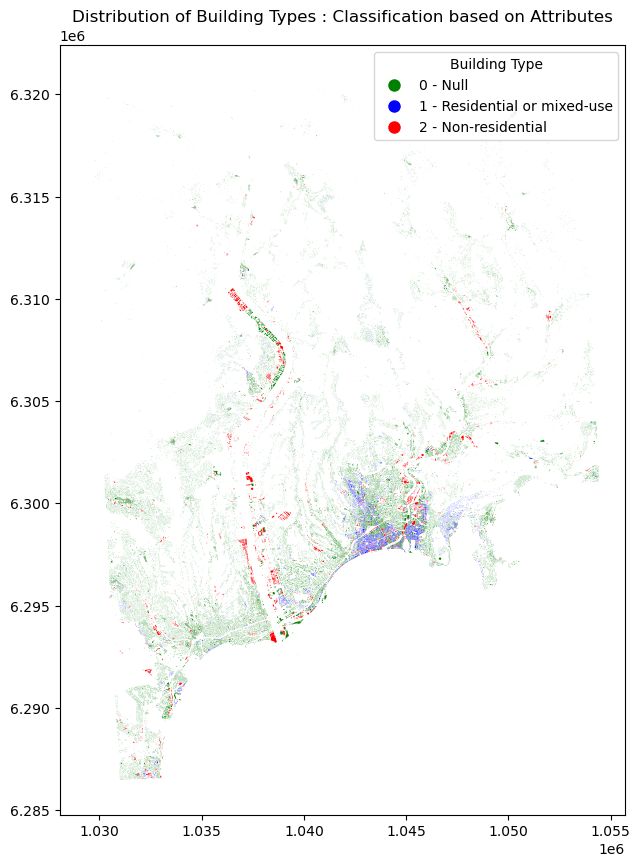

In [4]:
# A2. Map & Statistics
# Print the percentage and count of each building type
feature_counts = joined_data['type'].value_counts()
type_counts = joined_data['type'].value_counts(normalize=True) * 100
print("Percentage and count of building types using attribute values, specialized columns & landuse")
for type_code, percentage in type_counts.items():
    feature_count = feature_counts[type_code]
    if type_code == 0:
        print(f"0 : Null: {percentage:.2f}% ({feature_count} buildings)")
    elif type_code == 1:
        print(f"1 : Residential or mixed-use: {percentage:.2f}% ({feature_count} buildings)")
    else:
        print(f"2 : Non-residential: {percentage:.2f}% ({feature_count} buildings)")

columns_to_drop = ['index_right', 'element_type_right', 'osmid_right', 'landuse']
joined_data = joined_data.drop(columns=columns_to_drop)

# Plot with custom colors
colors = ['green', 'blue', 'red']
fig, ax = plt.subplots(figsize=(10, 10))
joined_data.plot(column='type', categorical=True, legend=True, ax=ax, cmap=ListedColormap(colors))
legend_labels = ['0 - Null', '1 - Residential or mixed-use', '2 - Non-residential']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(colors))]
ax.legend(handles, legend_labels, title='Building Type')
plt.title('Distribution of Building Types : Classification based on Attributes')
plt.show()

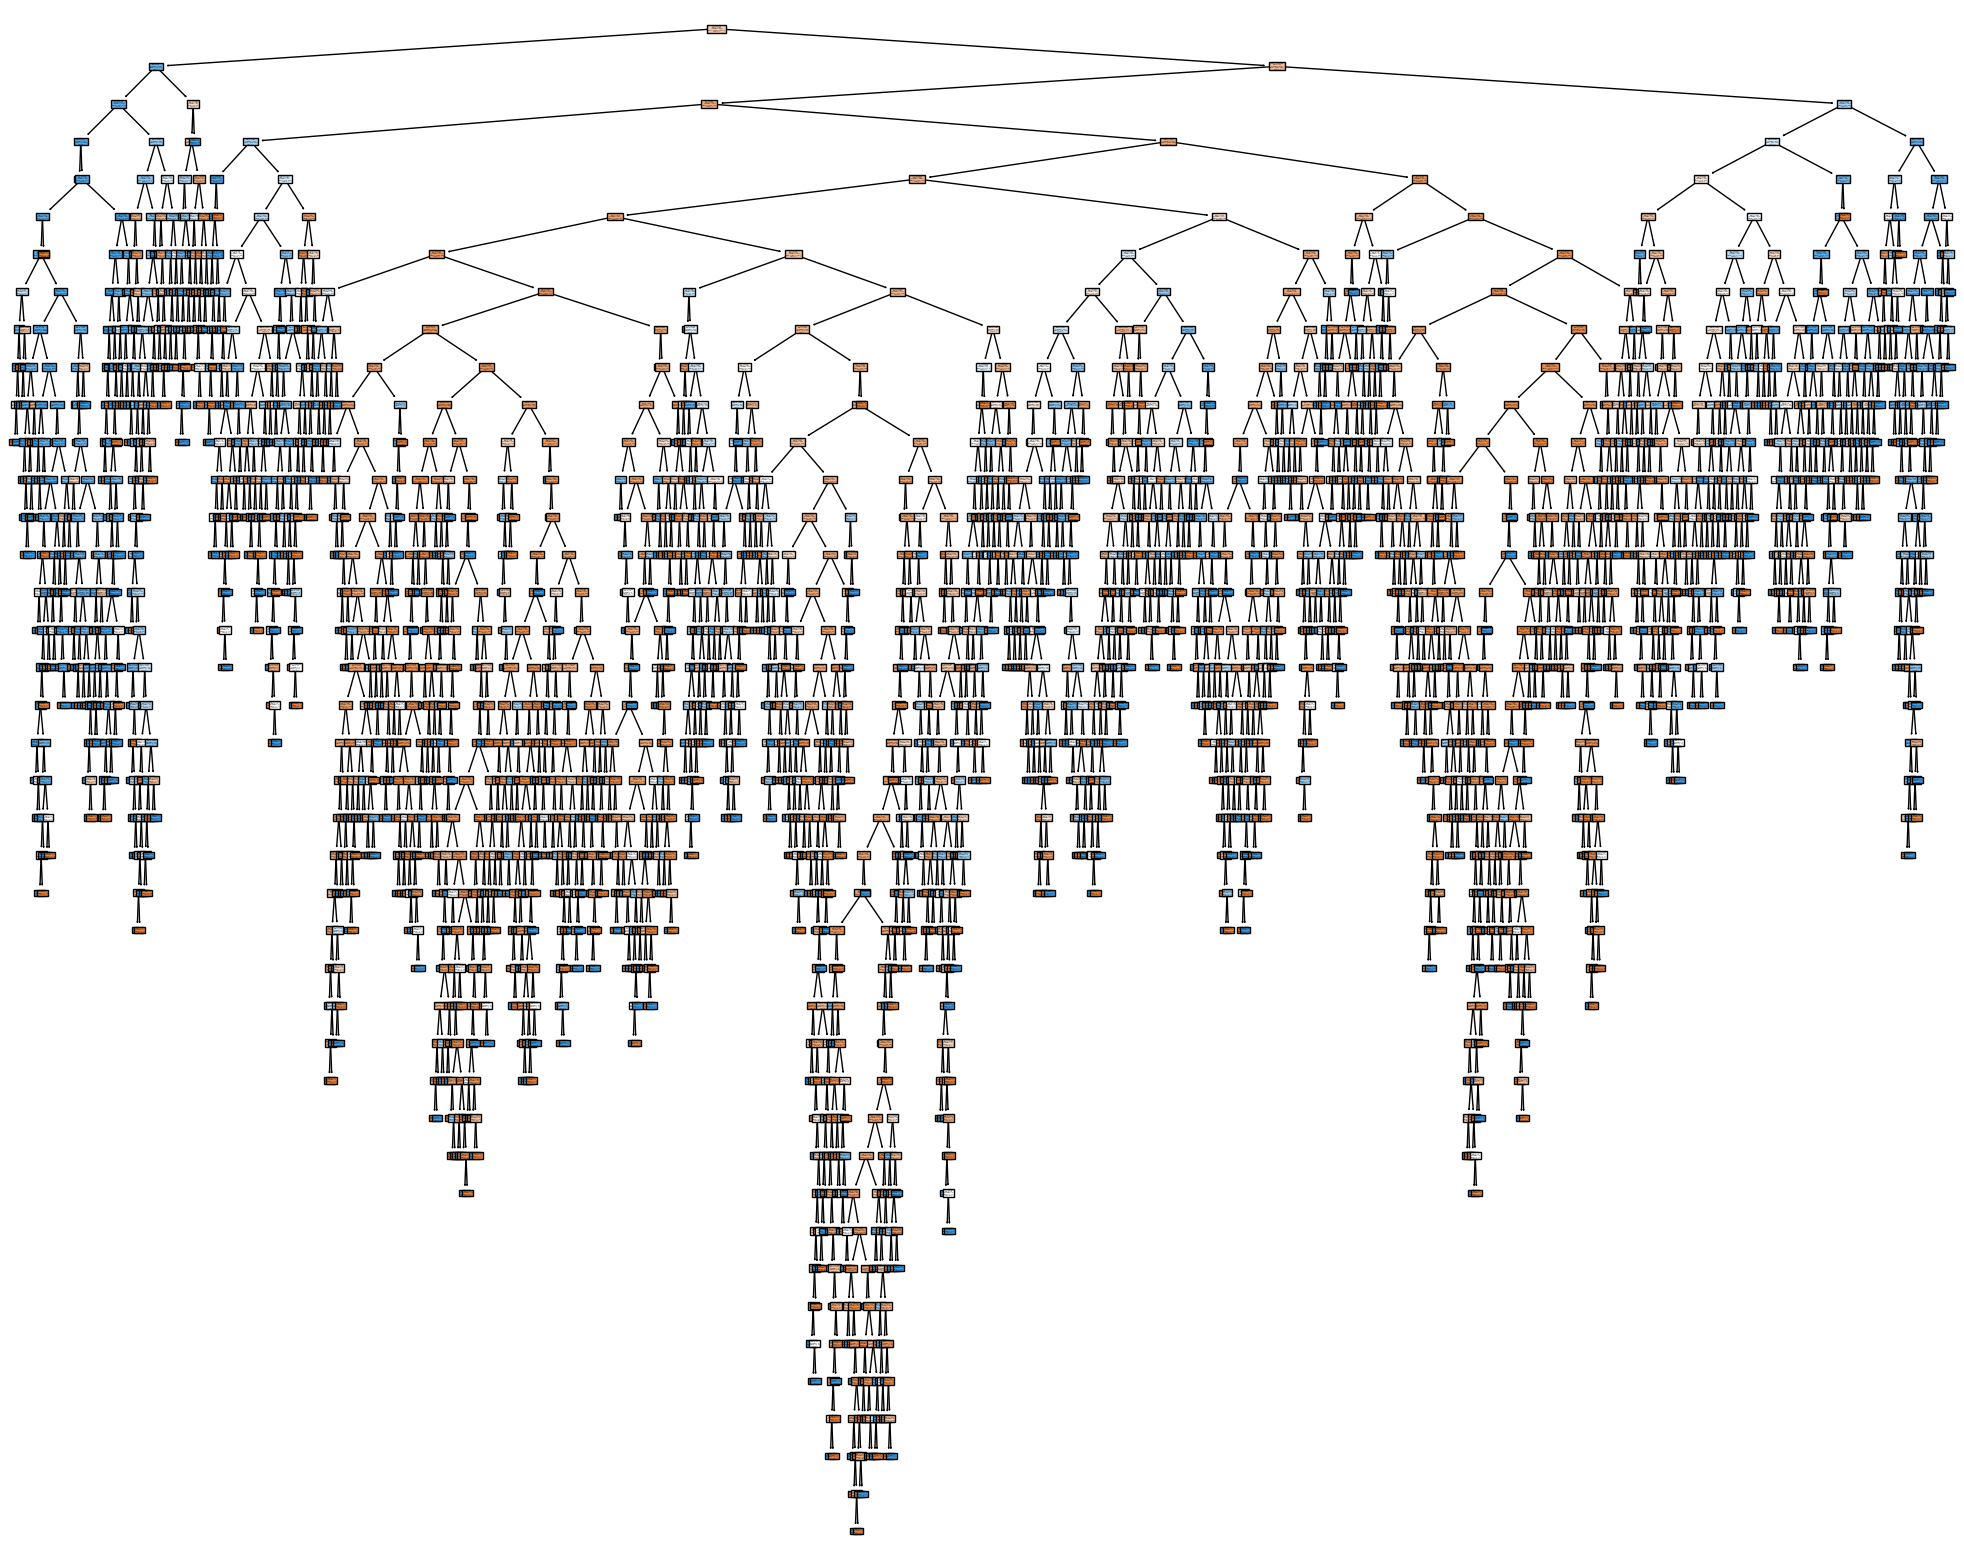

In [5]:
# A3. Tree Vizualization

# Visualize the decision tree
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns,  
                   class_names=['0', '1'],
                   filled=True)
plt.show()

Percentage and count of building types using attribute values, specialized columns, landuse and DTS model
1 : Residential or mixed-use: 60.51% (75619 buildings)
2 : Non-residential: 39.49% (49351 buildings)


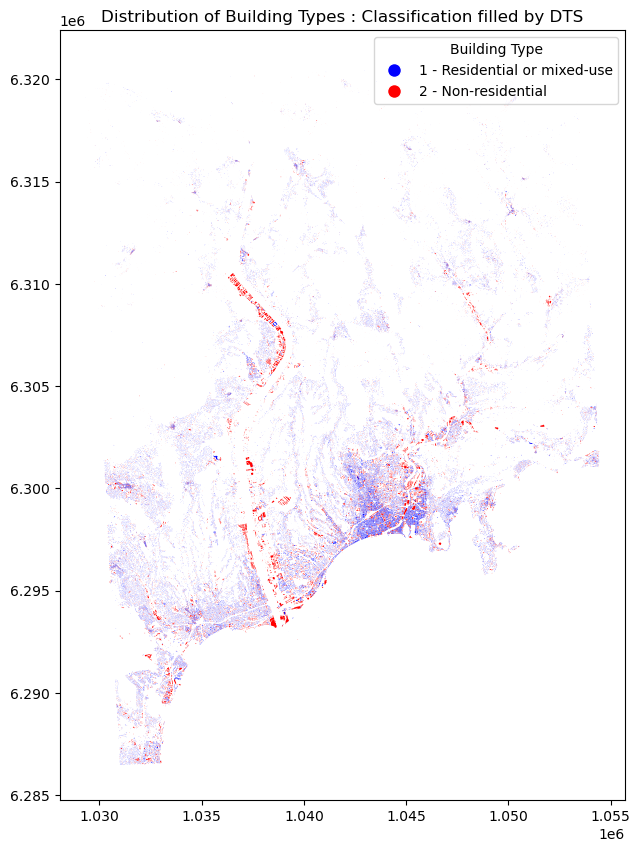

In [6]:
# A4. Map of residential buidlings filled by DTS

# Print the percentage and count of each building type
feature_counts = building_final['type_filled'].value_counts()
type_counts = building_final['type_filled'].value_counts(normalize=True) * 100
print("Percentage and count of building types using attribute values, specialized columns, landuse and DTS model")
for type_code, percentage in type_counts.items():
    feature_count = feature_counts[type_code]
    if type_code == 0:
        print(f"0 : NA: {percentage:.2f}% ({feature_count} buildings)")
    elif type_code == 1:
        print(f"1 : Residential or mixed-use: {percentage:.2f}% ({feature_count} buildings)")
    else:
        print(f"2 : Non-residential: {percentage:.2f}% ({feature_count} buildings)")

# Define custom colors
colors = ['blue', 'red']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
building_final.plot(column='type_filled', legend=False, ax=ax, cmap=ListedColormap(colors))

# Add custom legend
legend_labels = ['1 - Residential or mixed-use', '2 - Non-residential']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(colors))]
ax.legend(handles, legend_labels, title='Building Type')

# Add a title
plt.title('Distribution of Building Types : Classification filled by DTS')

# Show the plot
plt.show()

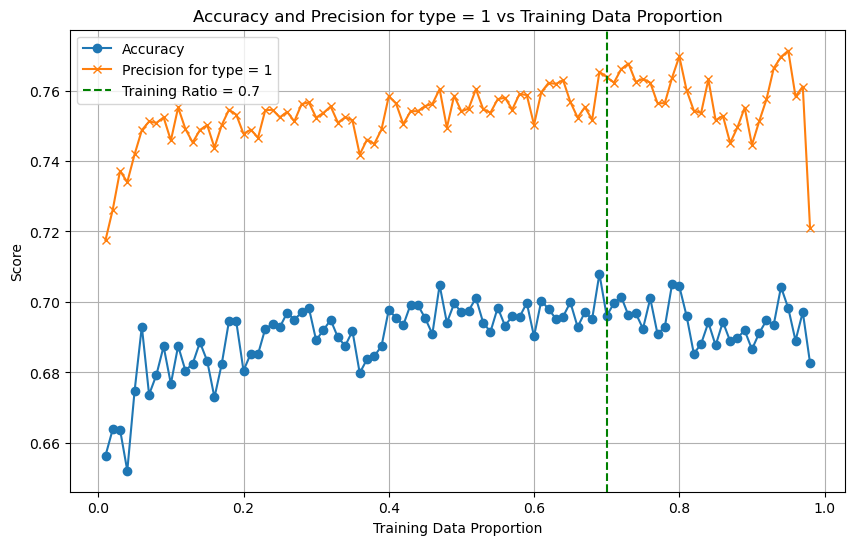

In [7]:
# A5. Compute Accuracy based on Trainning Data Size

# Define the proportions for training data
train_proportions = np.arange(0.01, 0.99, 0.01)

# Lists to store proportions, accuracies, and precision for type = 1
proportions_list = []
accuracies_list = []
precision_type_1_list = []

# Loop over each training proportion
for proportion in train_proportions:
    # Set a random seed for reproducibility
    np.random.seed(45)

    # Create a boolean mask for selecting the proportion of the data for training
    mask = np.random.rand(len(building_res)) < proportion

    # Split the data into training and testing sets
    data_train = building_res[mask]
    data_test = building_res[~mask]

    # Initialize the Decision Tree Classifier
    clf = DecisionTreeClassifier()

    # Separate the target variable and features for the training set
    X_train = data_train.drop(columns=['type'])
    y_train = data_train['type']

    # Train the classifier
    clf.fit(X_train, y_train)

    # Separate the features and target variable for the test set
    X_test = data_test.drop(columns=['type'])
    y_test = data_test['type']

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate precision for type = 1
    precision_type_1 = precision_score(y_test, y_pred, labels=[1], average='macro', zero_division=0)

    # Store the proportion, accuracy, and precision for type = 1
    proportions_list.append(proportion)
    accuracies_list.append(accuracy)
    precision_type_1_list.append(precision_type_1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(proportions_list, accuracies_list, marker='o', label='Accuracy')
plt.plot(proportions_list, precision_type_1_list, marker='x', label='Precision for type = 1')
plt.axvline(x=Training_ratio, color='green', linestyle='--', label=f'Training Ratio = {Training_ratio}')
plt.title('Accuracy and Precision for type = 1 vs Training Data Proportion')
plt.xlabel('Training Data Proportion')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()